GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name        | Type    | Params
----------------------------------------
0 | _loss       | MSELoss | 0     
1 | _neural_net | Network | 2.7 K 
----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 1/1 [00:02<00:00,  2.13s/it, v_num=4, gamma1_loss=0.00182, gamma2_loss=0.00299, gamma3_loss=0.00168, gamma4_loss=0.00301, D_loss=3.560, mean_loss=0.714]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 1/1 [00:02<00:00,  2.15s/it, v_num=4, gamma1_loss=0.00182, gamma2_loss=0.00299, gamma3_loss=0.00168, gamma4_loss=0.00301, D_loss=3.560, mean_loss=0.714]


C:\Users\Andrea\AppData\Local\Temp\ipykernel_12200\1891377929.py:161: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.gcf().savefig(nome + '_grafico_loss.pdf', format='pdf') # Qui per salvare il grafico della loss


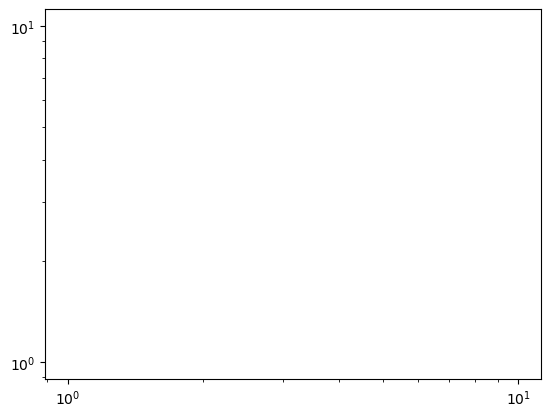

In [6]:
seed = 316683
nome = str(seed)  # Nome che voglio dare alla simulazione così da distinguere loss e plot per tutto
epochs = 1

import sys
sys.path.append('C:/Users/Andrea/Desktop/Poli/Tesi magistrale/reporitory_SISSA_PoliTO')

import argparse
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.nn import Softplus

from pina import LabelTensor
from pina.solvers import PINN
from pina.model import MultiFeedForward
from pina.plotter import Plotter
from pina.trainer import Trainer
from pina.model import FeedForward
from pina.callbacks import MetricTracker

from pina import Condition
from pina.geometry import CartesianDomain
from pina.equation import SystemEquation, FixedValue
from pina.problem import SpatialProblem, ParametricProblem
from pina.operators import laplacian

class ParametricEllipticOptimalControl(SpatialProblem, ParametricProblem):
    xmin, xmax, ymin, ymax = -1, 1, -1, 1    # setting spatial variables ranges
    x_range = [xmin, xmax]
    y_range = [ymin, ymax]
    # setting parameters range
    mu1min, mu1max = 0.5, 3
    mu2min, mu2max = 0.01, 1
    mu1_range = [mu1min, mu1max]
    mu2_range = [mu2min, mu2max]
    output_variables = ['u', 'y', 'z']    # setting field variables
    # setting spatial and parameter domain
    spatial_domain = CartesianDomain({'x1': x_range, 'x2': y_range})
    parameter_domain = CartesianDomain({'mu1': mu1_range, 'mu2': mu2_range})

    # equation terms as in https://arxiv.org/pdf/2110.13530.pdf
    def term1(input_, output_):
        laplace_z = laplacian(output_, input_, components=['z'], d=['x1', 'x2'])
        return output_.extract(['y']) - laplace_z - input_.extract(['mu1'])

    def term2(input_, output_):
        laplace_y = laplacian(output_, input_, components=['y'], d=['x1', 'x2'])
        return - laplace_y - output_.extract(['u'])

    # setting problem condition formulation
    conditions = {
        'gamma1': Condition(
            location=CartesianDomain({'x1': x_range, 'x2': 1, 'mu1': mu1_range, 'mu2': mu2_range}),
            equation=FixedValue(0, ['z', 'y'])),
        'gamma2': Condition(
            location=CartesianDomain({'x1': x_range, 'x2': -1, 'mu1': mu1_range, 'mu2': mu2_range}),
            equation=FixedValue(0, ['z', 'y'])),
        'gamma3': Condition(
            location=CartesianDomain({'x1': 1, 'x2': y_range, 'mu1': mu1_range, 'mu2': mu2_range}),
            equation=FixedValue(0, ['z', 'y'])),
        'gamma4': Condition(
            location=CartesianDomain({'x1': -1, 'x2': y_range, 'mu1': mu1_range, 'mu2': mu2_range}),
            equation=FixedValue(0, ['z', 'y'])),
        'D': Condition(location=CartesianDomain({'x1': x_range, 'x2': y_range, 'mu1': mu1_range, 'mu2': mu2_range}),
                       equation=SystemEquation([term1, term2], reduction='sum')), #Senza il reduction sum c'è un bias nella loss
    }


#############################################


# EXTRA FEATURE
class myFeature(torch.nn.Module):
    """
    Feature: sin(x)
    """

    def __init__(self):
        super(myFeature, self).__init__()

    def forward(self, x):
        t = (-x.extract(['x1']) ** 2 + 1) * (-x.extract(['x2']) ** 2 + 1)
        return LabelTensor(t, ['k0'])


# Nuovo tipo di modello (fatto da Dario)
class CustomMultiDFF(torch.nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__()
        self.model = FeedForward(*args, **kwargs)

    def forward(self, x):
        out = self.model(x)
        out.labels = ['u', 'y']
        z = LabelTensor((out.extract(['u']) * x.extract(['mu2'])), ['z'])
        return out.append(z)

if __name__ == "__main__":
    torch.manual_seed(seed)
    flag_extra_feature = 1
    parser = argparse.ArgumentParser(description="Run PINA")
    parser.add_argument("--load", help="directory to save or load file", type=str)
    parser.add_argument("--features", help="extra features", type=int, default=flag_extra_feature)
    parser.add_argument("--epochs", help="extra features", type=int, default=epochs)
    parser.add_argument('-f')  # Serve per risolvere l'errore di sotto
    args = parser.parse_args()

    if args.features is None:
        args.features = 0

    # extra features
    feat = [myFeature()] if args.features else []
    args = parser.parse_args()

    # create problem and discretise domain
    opc = ParametricEllipticOptimalControl()
    opc.discretise_domain(n=900, mode='random', variables=['x1', 'x2'], locations=['D'])
    opc.discretise_domain(n=50, mode='random', variables=['mu1', 'mu2'], locations=['D'])
    opc.discretise_domain(n=200, mode='random', variables=['x1', 'x2'],
                          locations=['gamma1', 'gamma2', 'gamma3', 'gamma4'])
    opc.discretise_domain(n=50, mode='random', variables=['mu1', 'mu2'],
                          locations=['gamma1', 'gamma2', 'gamma3', 'gamma4'])

    model = CustomMultiDFF(
        input_dimensions=4+len(feat),
        output_dimensions=2,
        layers=[40, 40, 20],
        func=Softplus
    )
    # Creazione dell''stanza di PINN
    pinn = PINN(problem=opc, model=model, optimizer_kwargs={'lr': 0.002}, extra_features=feat)
    # Creazione di istanza di Trainer
    directory = 'pina.parametric_optimal_control_{}'.format(bool(args.features))
    trainer = Trainer(solver=pinn, accelerator='cpu', max_epochs=args.epochs)  # callbacks = [MetricTracker()], si può anche usare le gpu se uso la workstation
    
    # Training
    trainer.train()

###############################################
####################################### GRAFICI
plotter = Plotter()
plotter.plot(pinn, fixed_variables={'mu1': 3, 'mu2': 1}, components='u', filename=nome + '_u.png')
plotter.plot(pinn, fixed_variables={'mu1': 3, 'mu2': 1}, components='y', filename=nome + '_y.png')
plotter.plot(pinn, fixed_variables={'mu1': 3, 'mu2': 1}, components='z', filename=nome + '_z.png')

################################################
########################################### LOSS
#Qui salvo la loss function
andamento_loss = trainer._model.lossVec
def salva_variabile(file, variabile):
    with open(file, 'w') as f:
        f.write(repr(variabile))

# Chiama la funzione per salvare la variabile
salva_variabile('loss_'+ nome +'.txt', andamento_loss) #Qui per salvare la loss

# Grafico loss
plt.loglog(andamento_loss)
plt.gcf().savefig(nome + '_grafico_loss.pdf', format='pdf') # Qui per salvare il grafico della loss

#############################################CALCOLO DELLA NORMA l2 PER TUTTI GLI OUTPUT

# n = 638
# path = "/home/atataranni/PINA/Codici/Parametric_elliptic/FEM_Elliptic"

# fem_u = torch.tensor(np.load(path + "/alpha_1/control.npy"), dtype=torch.float).view(-1, 1)
# fem_z = torch.tensor(np.load(path + "/alpha_1/adjoint.npy"), dtype=torch.float).view(-1, 1)
# fem_y = torch.tensor(np.load(path + "/alpha_1/state.npy"), dtype=torch.float).view(-1, 1)
# X = torch.tensor(np.load(path + "/alpha_1/x.npy"), dtype=torch.float).view(-1, 1)
# Y = torch.tensor(np.load(path + "/alpha_1/y.npy"), dtype=torch.float).view(-1, 1)

# x_labelT = LabelTensor(X, ['x1'])
# y_labelT = LabelTensor(Y, ['x2'])
# mu1_labelT = LabelTensor(torch.full((n,), 3, dtype=torch.float).view(-1, 1), ['mu1'])
# mu2_labelT = LabelTensor(torch.full((n,), 1, dtype=torch.float).view(-1, 1), ['mu2'])
# input = x_labelT.append(y_labelT).append(mu1_labelT).append(mu2_labelT)

# output = pinn.forward(input)
# output.labels = ['u', 'y', 'z']

# errore_u = (output.extract(['u']) - fem_u).reshape(n,)
# errore_y = (output.extract(['y']) - fem_y).reshape(n,)
# errore_z = (output.extract(['z']) - fem_z).reshape(n,)

# norma_errore_u = torch.dot(errore_u, errore_u).item()
# norma_errore_y = torch.dot(errore_y, errore_y).item()
# norma_errore_z = torch.dot(errore_z, errore_z).item()

# with open(nome + 'l2_errors.txt', 'w') as file:
#     file.write(f"norma_errore_u = {norma_errore_u}\n")
#     file.write(f"norma_errore_y = {norma_errore_y}\n")
#     file.write(f"norma_errore_z = {norma_errore_z}\n")



In [14]:
print(opc.conditions)

{'gamma1': <pina.condition.Condition object at 0x0000027D36F6D310>, 'gamma2': <pina.condition.Condition object at 0x0000027D37294900>, 'gamma3': <pina.condition.Condition object at 0x0000027D37294CC0>, 'gamma4': <pina.condition.Condition object at 0x0000027D372947C0>, 'D': <pina.condition.Condition object at 0x0000027D37294770>}
